In [184]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import pdir as pr
import pandas as pd
import os
from tqdm import tqdm, tnrange, tqdm_notebook

DF = pd.DataFrame
arr = np.array

# 读取数据集

In [185]:
dirPath2 = "E:\\Code\\_largeData\\Github--Open-Course-Learning--A04\\Project\\multiclass classification\\data preprocessed\\wordvec_6B_50d - TA version" 
dirPath = "E:\\Code\\_largeData\\Github--Open-Course-Learning--A04\\Project\\multiclass classification\\data preprocessed\\tf-idf"
# dirPath2 = dirPath2  +"\\without removing stopwords"

trainSet = np.loadtxt(dirPath2 + '\\train.csv', delimiter=",")
validateSet = np.loadtxt(dirPath2 + '\\validate.csv', delimiter=",")
testSet = np.loadtxt(dirPath2 + '\\test.csv', delimiter=",")


trainSetLabel = np.loadtxt(dirPath + '\\train_label.csv', delimiter=",")
validateSetLabel = np.loadtxt(dirPath + '\\validate_label.csv', delimiter=",")

trainSet.shape, validateSet.shape, testSet.shape

trainSetLabel.shape, validateSetLabel.shape

((43766, 50), (18756, 50), (8671, 50))

((43766,), (18756,))

In [186]:
Counter(trainSetLabel)
Counter(validateSetLabel)

Counter({0.0: 13606, 1.0: 18255, 2.0: 11905})

Counter({0.0: 5692, 1.0: 7802, 2.0: 5262})

## 实现OVO

由于有OVO和OVA两种方式可选，但是在三元分类上，OVO的效果从理论上应比OVA的好，因此直接选择OVO。

两者需要跑的子模型是一样的。

为适应LR的模型输入，需要把不同类别的标签转换为0和1.

In [187]:
mp = {"01":{0:0, 1:1}, "02":{0:0, 2:1}, "12":{1:0, 2:1}}
mp["01"]
mp["02"]
mp["12"]

{0: 0, 1: 1}

{0: 0, 2: 1}

{1: 0, 2: 1}

01

In [188]:
idx_01 = np.logical_or(trainSetLabel == 0, trainSetLabel == 1)
trainSet_01 = trainSet[idx_01]
trainSetLabel_01 = trainSetLabel[idx_01]

trainSet_01.shape, trainSetLabel_01.shape

np.place(trainSetLabel_01, trainSetLabel_01==0, 0)
np.place(trainSetLabel_01, trainSetLabel_01==1, 1)
Counter(trainSetLabel_01)

((31861, 50), (31861,))

Counter({0.0: 13606, 1.0: 18255})

02

In [189]:
idx_02 = np.logical_or(trainSetLabel == 0, trainSetLabel == 2)
trainSet_02 = trainSet[idx_02]
trainSetLabel_02 = trainSetLabel[idx_02]

trainSet_02.shape, trainSetLabel_02.shape

np.place(trainSetLabel_02, trainSetLabel_02==0, 0)
np.place(trainSetLabel_02, trainSetLabel_02==2, 1)
Counter(trainSetLabel_02)

((25511, 50), (25511,))

Counter({0.0: 13606, 1.0: 11905})

12

In [190]:
idx_12 = np.logical_or(trainSetLabel == 1, trainSetLabel == 2)
trainSet_12 = trainSet[idx_12]
trainSetLabel_12 = trainSetLabel[idx_12]

trainSet_12.shape, trainSetLabel_12.shape

np.place(trainSetLabel_12, trainSetLabel_12==1, 0)
np.place(trainSetLabel_12, trainSetLabel_12==2, 1)
Counter(trainSetLabel_12)

((30160, 50), (30160,))

Counter({0.0: 18255, 1.0: 11905})

# 逻辑回归

In [191]:
class LogisticRegression:
    '''逻辑回归类实现'''
    
    def __addOne2Samples(self, dataSet):
        '''给每一个样本前加一个常数1'''
        ones = np.ones(len(dataSet))
        return np.column_stack((ones, dataSet))
    
    def sigmoid(self, x):
        '''sigmoid函数实现'''
        return 1/(1+np.exp(-1*x))
    
    def fit(self, trainSet, label, eta=1e-3, maxRunTimes=100):
        '''根据给定的训练集和标签训练PLA的参数 w '''
        #设置默认的 w 全为1
        self.w = np.mat(np.ones(trainSet.shape[1]+1)).reshape(-1,1)
        #给训练集中每一个样本前加一个常数1，并转换为numpy矩阵
        trainSet = np.mat(self.__addOne2Samples(trainSet))
        #将标签转换为numpy矩阵，并将其设置为只有一列的数据的矩阵
        label = np.mat(label).reshape(-1,1)
        for i in range(maxRunTimes):
            eta_reduced = eta/(1+i)+1e-7
            #根据矩阵运算得到整个数据集每个维度梯度
            gradient = trainSet.T*(self.sigmoid(trainSet*self.w) - label)
            #更新 w
            self.w -= eta_reduced*gradient
        
    def __apply(self, x):
        '''利用训练好的 w 对输入的向量x进行分类'''
        w = np.array(self.w)[:,0] #转换为numpy向量，方便后续计算
        return 1 if self.sigmoid(np.dot(w, x)) > 0.5 else 0
    
    def apply(self, otherSet):
        '''根据已训练出的 w 对其他数据集进行划分'''
        otherSet = self.__addOne2Samples(otherSet)
        outputLabel = np.zeros(otherSet.shape[0])
        for index, sample in enumerate(otherSet):
            outputLabel[index] = self.__apply(sample)
        return outputLabel
    
    def getW(self):
        return np.array(self.w)[:,0]

# 计算平均准确率

In [192]:
def calcAvg(predict, actual):
    all_labels = list(set(actual))
    tot = 0.0
    for i in all_labels:
        counter = Counter(predict[actual == i] == i)
        hit_num, miss_num = counter[True], counter[False]
        tot += hit_num / (hit_num + miss_num)
    return tot/len(all_labels)

calcAvg(arr([1,2,3]), arr([3,2,1]))

0.3333333333333333

# 绘制图像

In [193]:
def show_fig(testRange, avgs):
    fig,ax = plt.subplots() 
    fig.set_size_inches(10, 4)
    plt.plot(testRange, avgs, 'g')
    plt.xlabel('eta')
    plt.ylabel('avg(%)')
    plt.title("avg versus eta with Logistic Regression")
    plt.show()
    plt.close()

# 调参

暂调参数eta，暂定迭代次数为1000，不设置正则化项。

In [194]:
a = arr([1,1,2,1])
b = arr([1,2,0,2])
c = arr([2,0,0,2])

d = np.vstack([a,b,c])
d
for i in range(d.shape[1]):
    t = Counter(d[:, i]).most_common(2)
    print(t)
    if t[0][1] == t[1][1]:
        print(1)
    else:
        print(t[0][0])

array([[1, 1, 2, 1],
       [1, 2, 0, 2],
       [2, 0, 0, 2]])

[(1, 2), (2, 1)]
1
[(0, 1), (1, 1)]
1
[(0, 2), (2, 1)]
0
[(2, 2), (1, 1)]
2


[0.1]

array([ 500,  550,  600,  650,  700,  750,  800,  850,  900,  950, 1000,
       1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550,
       1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100,
       2150, 2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650,
       2700, 2750, 2800, 2850, 2900, 2950, 3000, 3050])

0.1 Counter({2.0: 9095, 0.0: 8854, 1.0: 807})
avg :  0.4279858929499767 runtime :  500
0.1 Counter({2.0: 9087, 0.0: 8785, 1.0: 884})
avg :  0.42877883788382204 runtime :  550
0.1 Counter({2.0: 9066, 0.0: 8696, 1.0: 994})
avg :  0.427690493807857 runtime :  600
0.1 Counter({2.0: 9048, 0.0: 8634, 1.0: 1074})
avg :  0.4275328838724734 runtime :  650
0.1 Counter({2.0: 9013, 0.0: 8580, 1.0: 1163})
avg :  0.4271380683176143 runtime :  700
0.1 Counter({2.0: 8979, 0.0: 8491, 1.0: 1286})
avg :  0.42689943027818744 runtime :  750
0.1 Counter({2.0: 8948, 0.0: 8391, 1.0: 1417})
avg :  0.4257205001073605 runtime :  800
0.1 Counter({2.0: 8952, 0.0: 8239, 1.0: 1565})
avg :  0.4250026620081744 runtime :  850
0.1 Counter({2.0: 8923, 0.0: 8070, 1.0: 1763})
avg :  0.4251547843782481 runtime :  900
0.1 Counter({2.0: 8899, 0.0: 7864, 1.0: 1993})
avg :  0.42528627046589756 runtime :  950
0.1 Counter({2.0: 8868, 0.0: 7594, 1.0: 2294})
avg :  0.42429881070132963 runtime :  1000
0.1 Counter({2.0: 8846, 0.0: 71

(550, 0.42877883788382204)

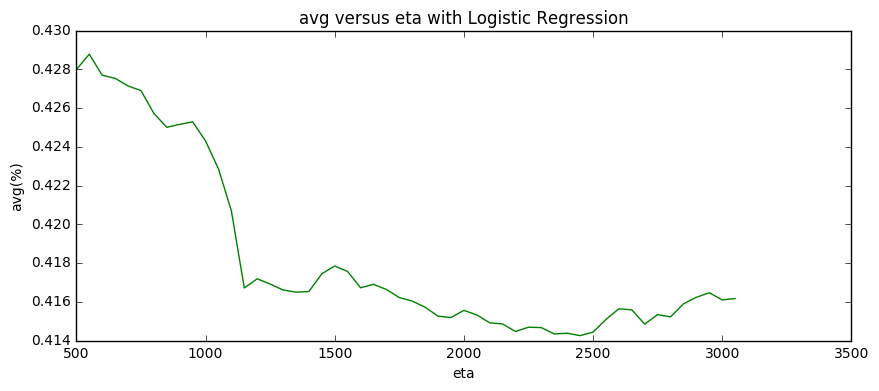

In [197]:
def runLR(dataSet, eta, runtime=1000):
    LR_01, LR_02, LR_12 = LogisticRegression(), LogisticRegression(), LogisticRegression()
    
    LR_01.fit(trainSet_01, trainSetLabel_01, eta=eta, maxRunTimes=runtime)
    LR_02.fit(trainSet_02, trainSetLabel_02, eta=eta, maxRunTimes=runtime)
    LR_12.fit(trainSet_12, trainSetLabel_12, eta=eta, maxRunTimes=runtime)
    
    ansLabel_01 = LR_01.apply(dataSet)
#     np.place(ansLabel_01, ansLabel_01==0, 0)
#     np.place(ansLabel_01, ansLabel_01==1, 1)
    
    ansLabel_02 = LR_02.apply(dataSet)
    np.place(ansLabel_02, ansLabel_02==0, 0)
    np.place(ansLabel_02, ansLabel_02==1, 2)
    
    ansLabel_12 = LR_12.apply(dataSet)
    np.place(ansLabel_12, ansLabel_12==0, 1)
    np.place(ansLabel_12, ansLabel_12==1, 2)    
    
    labels = np.vstack([ansLabel_01, ansLabel_02, ansLabel_12])
    ansLabel = np.zeros(labels.shape[1])
    
    for i in tnrange(labels.shape[1], leave=False):
        t = Counter(labels[:, i]).most_common(2)
        #print(t)
        if t[0][1] == t[1][1]:
            ansLabel[i] = 1 #默认选择MID
        else:
            ansLabel[i] =  t[0][0]
    
    print(eta, Counter(ansLabel))
    
    return ansLabel
    

def getTestAvg(eta, runtime):
    ansLabel = runLR(validateSet, eta, runtime)
    avg = calcAvg(ansLabel, validateSetLabel)
    print("avg : ", avg, "runtime : ", runtime)
    return avg
    
# etaTestRange = [0.0005, 0.0010, 0.0050, 0.0100, 0.0500, 0.1000, 0.5000, 1, 5]
# etaTestRange = np.arange(5,6.1,0.1)
# etaTestRange = np.arange(0.01 ,0.11, 0.01)
# etaTestRange = np.arange(0.045 ,0.055, 0.001)
etaTestRange = [0.1]
etaTestRange 

runtimeTestRange = np.arange(500, 3100, 50)
# runtimeTestRange = np.arange(900, 1100, 25)
# runtimeTestRange = np.arange(1000, 1200, 10)
# runtimeTestRange = [1000]
runtimeTestRange

avgs = []
for i in tnrange(len(runtimeTestRange)):
    avgs.append(getTestAvg(etaTestRange[0], runtimeTestRange[i]))
    
# bestEta = etaTestRange[np.argmax(avgs)]
# bestEta, np.max(avgs) 

bestRuntime = runtimeTestRange[np.argmax(avgs)]
bestRuntime, np.max(avgs) 

show_fig(runtimeTestRange, avgs)

In [198]:
ansLabel = runLR(testSet, 0.1, 550)
Counter(ansLabel)

0.1 Counter({2.0: 4154, 0.0: 4108, 1.0: 409})


Counter({0.0: 4108, 1.0: 409, 2.0: 4154})

In [199]:
ans = DF(ansLabel).replace(0, "LOW").replace(1, "MID").replace(2, "HIG")
ans.to_csv('.\\rank\\47_v6.csv', index=False, header=False)